Check GPU and instantiate model - will download weights.

In [1]:
import numpy as np
from cellpose import models, core, io, plot
from pathlib import Path
from tqdm import trange
import matplotlib.pyplot as plt
from natsort import natsorted

io.logger_setup() # run this to get printing of progress

#Check if colab notebook instance has GPU access
if core.use_gpu()==False:
  raise ImportError("No GPU access, change your runtime")

model = models.CellposeModel(gpu=True)

2025-11-03 15:59:33,987 [INFO] WRITING LOG OUTPUT TO /Users/gmgao/.cellpose/run.log
2025-11-03 15:59:33,988 [INFO] 
cellpose version: 	4.0.7 
platform:       	darwin 
python version: 	3.10.19 
torch version:  	2.9.0
2025-11-03 15:59:34,000 [INFO] ** TORCH MPS version installed and working. **
2025-11-03 15:59:34,001 [INFO] ** TORCH MPS version installed and working. **
2025-11-03 15:59:34,001 [INFO] >>>> using GPU (MPS)
2025-11-03 15:59:34,633 [INFO] >>>> loading model /Users/gmgao/.cellpose/models/cpsam


Input directory with your images:

In [2]:
dir = "/Volumes/guttman/Guoming_Gao-Resnick/Imaging_ProcessedData/C9_paper/20250912-C9in1b_odd_even/composite"
dir = Path(dir)
if not dir.exists():
    raise FileNotFoundError("directory does not exist")

# *** change to your image extension ***
image_ext = ".tif"

# list all files
files = natsorted(
    [
        f
        for f in dir.glob("*" + image_ext)
        if "_masks" not in f.name and "_flows" not in f.name
    ]
)

if len(files) == 0:
    raise FileNotFoundError(
        "no image files found, did you specify the correct folder and extension?"
    )
else:
    print(f"{len(files)} images in folder:")

for f in files:
    print(f.name)

21 images in folder:
5280-DAPI-488_C9In1bOdd-Cy5_C9In1bEven_1_MMStack_Pos0.ome_composite_stack.tif
10689-DAPI-488_C9In1bOdd-Cy5_C9In1bEven_1_MMStack_Pos0.ome_composite_stack.tif
10689-DAPI-488_C9In1bOdd-Cy5_C9In1bEven_2_MMStack_Pos0.ome_composite_stack.tif
10689-DAPI-488_C9In1bOdd-Cy5_C9In1bEven_3_MMStack_Pos0.ome_composite_stack.tif
10689-DAPI-488_C9In1bOdd-Cy5_C9In1bEven_4_MMStack_Pos0.ome_composite_stack.tif
10689-DAPI-488_C9In1bOdd-Cy5_C9In1bEven_5_MMStack_Pos0.ome_composite_stack.tif
10689-DAPI-488_C9In1bOdd-Cy5_C9In1bEven_6_MMStack_Pos0.ome_composite_stack.tif
10689-DAPI-488_C9In1bOdd-Cy5_C9In1bEven_7_MMStack_Pos0.ome_composite_stack.tif
10689-DAPI-488_C9In1bOdd-Cy5_C9In1bEven_8_MMStack_Pos0.ome_composite_stack.tif
10689-DAPI-488_C9In1bOdd-Cy5_C9In1bEven_9_MMStack_Pos0.ome_composite_stack.tif
10689-DAPI-488_C9In1bOdd-Cy5_C9In1bEven_10_MMStack_Pos0.ome_composite_stack.tif
12099-DAPI-488_C9In1bOdd-Cy5_C9In1bEven_1_MMStack_Pos0.ome_composite_stack.tif
12099-DAPI-488_C9In1bOdd-Cy5_C9

## Run Cellpose-SAM on one image in folder

Here are some of the parameters you can change:

* ***flow_threshold*** is  the  maximum  allowed  error  of  the  flows  for  each  mask.   The  default  is 0.4.
    *  **Increase** this threshold if cellpose is not returning as many masks as you’d expect (or turn off completely with 0.0)
    *   **Decrease** this threshold if cellpose is returning too many ill-shaped masks.

* ***cellprob_threshold*** determines proability that a detected object is a cell.   The  default  is 0.0.
    *   **Decrease** this threshold if cellpose is not returning as many masks as you’d expect or if masks are too small
    *   **Increase** this threshold if cellpose is returning too many masks esp from dull/dim areas.

* ***tile_norm_blocksize*** determines the size of blocks used for normalizing the image. The default is 0, which means the entire image is normalized together.
  You may want to change this to 100-200 pixels if you have very inhomogeneous brightness across your image.



(3, 2048, 2048) 51074.0
your image has shape: (3, 2048, 2048). Assuming channel dimension is last with 2048 channels


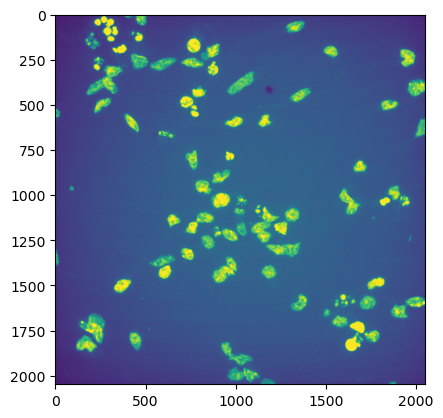

In [3]:
img = io.imread(files[5])

print(img.shape, np.ptp(img))

print(
    f"your image has shape: {img.shape}. Assuming channel dimension is last with {img.shape[-1]} channels"
)

# Check channels
img_test = img[2,:,:]
plt.imshow(img_test, vmax=np.quantile(img_test,0.99))

### Channel Selection: 

- Use the dropdowns below to select the _zero-indexed_ channels of your image to segment. The order does not matter. Remember to rerun the cell after you edit the dropdowns.

- If you have a histological image taken in brightfield, you don't need to adjust the channels.

- If you have a fluroescent image with multiple stains, you should choose one channel with a cytoplasm/membrane stain, one channel with a nuclear stain, and set the third channel to `None`. Choosing multiple channels may produce segmentaiton of all the structures in the image. If you have retrained the model on your data with a thrid stain (described below), you can run segmentation with all channels. 

In [4]:
# Cytoplasm/membrane stain
first_channel = "1"  # @param ['None', 0, 1, 2, 3, 4, 5]
# Nuclear stain
second_channel = "2"  # @param ['None', 0, 1, 2, 3, 4, 5]
# optional stain, leave none
third_channel = "None"  # @param ['None', 0, 1, 2, 3, 4, 5]
selected_channels = []
for i, c in enumerate([first_channel, second_channel, third_channel]):
    if c == "None":
        continue
    if int(c) > img.shape[-1]:
        assert (
            False
        ), "invalid channel index, must have index greater or equal to the number of channels"
    if c != "None":
        selected_channels.append(int(c))


def normalize_img(img_in):
    img_float = img_in.astype(np.float32)
    max_val = np.max(img_float)
    if max_val > 0:
        img_float /= max_val
    return img_float


# Prepare your two-channel image (cyto in channel 0, nucleus in channel 1)
img_selected_channels = np.zeros_like(img)
img_selected_channels[: len(selected_channels), :, :] = normalize_img(
    img[selected_channels, :, :]
)

# --- 1. Segment WHOLE CELLS using both channels ---
masks_cells, flows_cells, styles_cells = model.eval(
    img_selected_channels,  # Contains both cyto (ch 0) and nucleus (ch 1)
    batch_size=32,
    diameter=80,
    flow_threshold=0.5,
    cellprob_threshold=0.0,
    normalize={"tile_norm_blocksize": 0},
)

# --- 2. Segment NUCLEI using only the nuclear channel ---
# Create a 3-channel image with nucleus in FIRST channel (the model expects this)
img_nuclei_only = np.zeros_like(img_selected_channels)
img_nuclei_only[0, :, :] = img_selected_channels[
    1, :, :
]  # Move nucleus to first position

masks_nuclei, flows_nuclei, styles_nuclei = model.eval(
    img_nuclei_only,
    batch_size=32,
    diameter=50,
    flow_threshold=0.5,
    cellprob_threshold=0.0,
    normalize={"tile_norm_blocksize": 0},
)

2025-11-03 15:59:48,288 [WARNING] Resizing is deprecated in v4.0.1+
2025-11-03 16:00:07,711 [WARNING] Resizing is deprecated in v4.0.1+


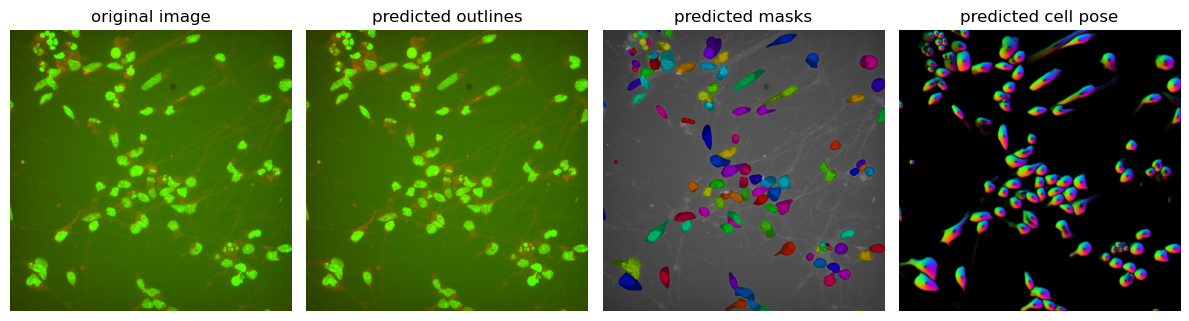

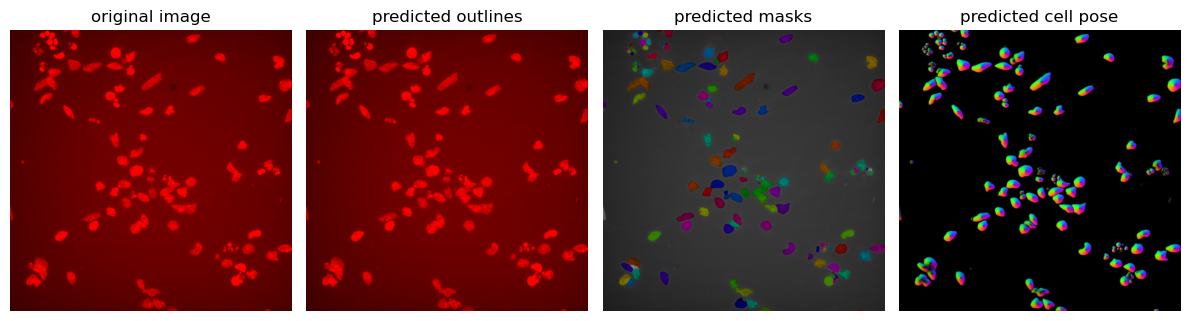

In [5]:
def examine_all(img_selected_channels, masks, flows):
    fig = plt.figure(figsize=(12, 5))
    vmin_target = 0.0
    vmax_target = np.percentile(img_selected_channels, 99.5)  # or try 99, 99.8, etc.
    img_display_adjusted = np.clip(
        (img_selected_channels - vmin_target) / (vmax_target - vmin_target + 1e-10),
        0,
        1,
    )
    plot.show_segmentation(
        fig,
        img_display_adjusted,
        masks,
        flows[0],
    )
    plt.tight_layout()
    plt.show()


examine_all(img_selected_channels, masks_cells, flows_cells)
examine_all(img_nuclei_only, masks_nuclei, flows_nuclei)

### Match cell and nucleus masks

In [6]:
import numpy as np


def create_compartment_masks_dict(masks_cells, masks_nuclei):
    """
    Create a comprehensive dictionary mapping cells to their nuclear and cytoplasmic compartments.

    Parameters:
    -----------
    masks_cells : 2D array of shape (H, W)
        Cell segmentation masks where each unique integer > 0 is a cell ID
    masks_nuclei : 2D array of shape (H, W)
        Nuclear segmentation masks where each unique integer > 0 is a nucleus ID

    Returns:
    --------
    cell_compartments : dict
        Dictionary with structure:
        {
            cell_id: {
                'nucleus_mask': binary mask (H, W),
                'cytoplasm_mask': binary mask (H, W),
                'cell_mask': binary mask (H, W),
                'nucleus_id': matched nucleus ID or None,
                'cell_area': int,
                'nucleus_area': int,
                'cytoplasm_area': int
            }
        }
    unmatched_nuclei : list
        List of nucleus IDs that don't overlap with any cell
    """

    cell_compartments = {}
    cell_ids = np.unique(masks_cells)[1:]  # Exclude background (0)
    nucleus_ids = np.unique(masks_nuclei)[1:]

    matched_nuclei = set()

    # Match each cell to its nucleus based on maximum overlap
    for cell_id in cell_ids:
        cell_mask = masks_cells == cell_id

        # Find overlapping nuclei
        overlaps = {}
        for nucleus_id in nucleus_ids:
            nucleus_mask = masks_nuclei == nucleus_id
            overlap_area = np.sum(cell_mask & nucleus_mask)
            if overlap_area > 0:
                overlaps[nucleus_id] = overlap_area

        if overlaps:
            # Get nucleus with maximum overlap
            best_nucleus_id = max(overlaps, key=overlaps.get)
            matched_nuclei.add(best_nucleus_id)
            nucleus_mask = masks_nuclei == best_nucleus_id
            cytoplasm_mask = cell_mask & (~nucleus_mask)

            cell_compartments[int(cell_id)] = {
                "nucleus_mask": nucleus_mask,
                "cytoplasm_mask": cytoplasm_mask,
                "cell_mask": cell_mask,
                "nucleus_id": int(best_nucleus_id),
                "cell_area": int(np.sum(cell_mask)),
                "nucleus_area": int(np.sum(nucleus_mask)),
                "cytoplasm_area": int(np.sum(cytoplasm_mask)),
            }
        else:
            # Cell without nucleus (rare but can happen)
            cell_compartments[int(cell_id)] = {
                "nucleus_mask": np.zeros_like(cell_mask),
                "cytoplasm_mask": cell_mask,
                "cell_mask": cell_mask,
                "nucleus_id": None,
                "cell_area": int(np.sum(cell_mask)),
                "nucleus_area": 0,
                "cytoplasm_area": int(np.sum(cell_mask)),
            }

    # Find unmatched nuclei
    unmatched_nuclei = [int(nid) for nid in nucleus_ids if nid not in matched_nuclei]

    return cell_compartments, unmatched_nuclei


def classify_spots(spots_coords, cell_compartments):
    """
    Classify spots as nuclear, cytoplasmic, or background.

    Parameters:
    -----------
    spots_coords : array-like of shape (N, 2)
        Spot coordinates as [(y1, x1), (y2, x2), ...]
    cell_compartments : dict
        Output from create_compartment_masks_dict

    Returns:
    --------
    spot_classifications : list of dict
        List containing classification info for each spot:
        [{
            'spot_id': int,
            'y': int, 'x': int,
            'cell_id': int or None,
            'compartment': 'nucleus', 'cytoplasm', or 'background',
            'nucleus_id': int or None
        }]
    """

    spot_classifications = []

    for spot_id, (y, x) in enumerate(spots_coords):
        y, x = int(y), int(x)
        classification = {
            "spot_id": spot_id,
            "y": y,
            "x": x,
            "cell_id": None,
            "compartment": "background",
            "nucleus_id": None,
        }

        # Check each cell
        for cell_id, compartments in cell_compartments.items():
            if compartments["cell_mask"][y, x]:
                classification["cell_id"] = cell_id

                # Check if in nucleus or cytoplasm
                if compartments["nucleus_mask"][y, x]:
                    classification["compartment"] = "nucleus"
                    classification["nucleus_id"] = compartments["nucleus_id"]
                else:
                    classification["compartment"] = "cytoplasm"

                break  # Found the cell, no need to check others

        spot_classifications.append(classification)

    return spot_classifications


# --- USE IT WITH YOUR DATA ---

# After your segmentation steps, create the compartment dictionary
cell_compartments, unmatched_nuclei = create_compartment_masks_dict(
    masks_cells, masks_nuclei
)

# Print summary
print(f"Matched {len(cell_compartments)} cells with their nuclei")
print(f"Unmatched nuclei: {len(unmatched_nuclei)}")
print()

# Examine each cell
for cell_id, comp in cell_compartments.items():
    print(
        f"Cell {cell_id}: nucleus_id={comp['nucleus_id']}, "
        f"cell_area={comp['cell_area']}, "
        f"nucleus_area={comp['nucleus_area']}, "
        f"cytoplasm_area={comp['cytoplasm_area']}"
    )

# Later, when you detect spots in another channel:
# spots_coords should be a list or array of (y, x) coordinates
# Example: spots_coords = [(100, 150), (200, 250), ...]

# spot_results = classify_spots(spots_coords, cell_compartments)

# You can then convert to a pandas DataFrame for analysis:
# import pandas as pd
# df_spots = pd.DataFrame(spot_results)
#
# # Count spots per compartment
# print(df_spots.groupby('compartment').size())
#
# # Count spots per cell
# print(df_spots.groupby('cell_id').size())

Matched 109 cells with their nuclei
Unmatched nuclei: 31

Cell 1: nucleus_id=1, cell_area=843, nucleus_area=1012, cytoplasm_area=70
Cell 2: nucleus_id=2, cell_area=3755, nucleus_area=3389, cytoplasm_area=411
Cell 3: nucleus_id=3, cell_area=1373, nucleus_area=1130, cytoplasm_area=243
Cell 4: nucleus_id=4, cell_area=1756, nucleus_area=1153, cytoplasm_area=605
Cell 5: nucleus_id=5, cell_area=1686, nucleus_area=1131, cytoplasm_area=556
Cell 6: nucleus_id=6, cell_area=9209, nucleus_area=4843, cytoplasm_area=4366
Cell 7: nucleus_id=17, cell_area=15618, nucleus_area=4992, cytoplasm_area=10626
Cell 8: nucleus_id=9, cell_area=1602, nucleus_area=1276, cytoplasm_area=326
Cell 9: nucleus_id=10, cell_area=2167, nucleus_area=1706, cytoplasm_area=462
Cell 10: nucleus_id=14, cell_area=5698, nucleus_area=1539, cytoplasm_area=4159
Cell 11: nucleus_id=13, cell_area=595, nucleus_area=393, cytoplasm_area=202
Cell 12: nucleus_id=16, cell_area=1365, nucleus_area=1004, cytoplasm_area=361
Cell 13: nucleus_id=1